## Using Textagon: Representation Informativeness

Now, having generated and scored our parallel representations, we can apply them for our downstream tasks.
In this sheet, we will look at informativeness. 

In [11]:
import pandas as pd

In [12]:
'''This is for regular parallel analysis'''

# Initialize empty lists to hold the data
labels = []
categories = []
counts = []

with open(f'./output/distress_key.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            labels.append(fields[3])
            categories.append('1-' + fields[2])

# Open the weights.txt file and read the data
with open(f'./output/distress_weights.txt', 'r') as f:
    for line in f:
        fields = line.split('\t')
        if len(fields) > 1:
            # labels.append(fields[0])
            counts.append(fields[3])

# Write the data to the output_key_FRN.txt file
with open(f'./output/distress_key_FRN.txt', 'w') as f:
    # No header as per your requirement
    for label, category, count in zip(labels, categories, counts):
        f.write(f'{label}\t{category}\t{count}')


In [13]:
'''This is for GBS parallel analysis'''

# open files
with open(f'./output/distress_key_GBS.txt', 'r') as output_file, open(f'./output/distress_weights.txt', 'r') as weights_file:
    output_lines = output_file.readlines()
    weights_lines = weights_file.readlines()

# prepare data to write
data_to_write = []

# loop over output lines
for i, output_line in enumerate(output_lines):
    output_line_parts = output_line.strip().split('\t')
    weights_line_parts = weights_lines[i].strip().split('\t')
    
    # Get data from both files
    first_column = output_line_parts[-1]
    second_column = output_line_parts[0]
    third_column = output_line_parts[1]
    fourth_column = weights_line_parts[-1]
    
    # Create a new line with the required format and append it to the list
    new_line = '\t'.join([first_column, second_column, third_column, fourth_column])
    data_to_write.append(new_line)

# write data to new file
with open(f'./output/distress_weights_GBS.txt', 'w') as weights_gbs_file:
    weights_gbs_file.write('\n'.join(data_to_write))


Next, we define some helper functions for running our tGBS.

In [14]:
import datetime 

def analyzeParallel(catStr, category, dfNodes):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[dfNodes['catstring'].str.fullmatch(category)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
            except:
                retToke+=1
    return totToke, retToke

def analyzeParallelGBS(catStr, category, dfNodes, threshold):
    paraFeat = open(catStr, "r", encoding='utf8')
    dfSub = dfNodes[(dfNodes['catstring'].str.fullmatch(category)) & (dfNodes['weight']>threshold)]
    totToke = 0
    retToke = 0
    print(catStr,len(dfSub))
    for position, line in enumerate(paraFeat):  
        if position%100==0:
            print(catStr,position, datetime.datetime.now().time())
        tokens = line[:-1].split(" ")
        totToke += len(tokens)
        #track retained nodes
        for count, value in enumerate(tokens):
            try:
                if (dfSub['label'].str.fullmatch(value)).any():       
                    retToke+=1
            except:
                retToke+=1
    return totToke, retToke


In [15]:
import zipfile
import os

# Specify the path to the zip file
zip_file_path = './output/distress_representations.zip'

# Specify the directory to extract files to
extract_to_directory = './output/distress_representations'

# Ensure the directory exists
os.makedirs(extract_to_directory, exist_ok=True)

# Open the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents
    zip_ref.extractall(extract_to_directory)

print(f"Files extracted to {extract_to_directory}")


Files extracted to ./output/distress_representations


In [16]:
import numpy as np

#Load DFs and concatenate weights...from GBS
threshold = 0.0000000001

lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./output/'

feature_path = folder_path + 'distress_key_FRN.txt'
dfFeat = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfFeat.columns = ['label', 'category', 'count']
dfFeat['catstring'] = dfFeat.category.str[2:]
dfFeat.set_index(['label', 'category'])

#load GBS weighted version
feature_path = folder_path + 'distress_weights_GBS.txt'
dfWeight = pd.read_csv(feature_path,sep='\t',header=None,encoding='latin1', quoting=3)
dfWeight.columns = ['featnum','label', 'category', 'weight']
dfWeight['catstring'] = dfWeight.category.str[2:]
dfWeight.set_index(['label', 'category'])

#concatenate
dfResult = pd.merge(dfFeat, dfWeight, how="right", on=["label", "category"], suffixes=('', '_y'))
dfResult.drop(dfResult.filter(regex='_y$').columns.tolist(),axis=1, inplace=True)
dfNodes = dfResult[dfResult['category'].str.contains('1-')]

for count, value in enumerate(lstCatsUse):
    OutputFile = open(f"{folder_path}{value}_result.csv","a",encoding='utf8')
    stats = np.zeros((len(lstCatsUse),2))
    rep = folder_path + 'distress_representations/' + 'distress_representation_' + value + '.txt'
    stats[count][0], stats[count][1] = analyzeParallelGBS(rep, value.upper(),dfNodes, threshold)
    OutputFile.write(value+","+str(count)+","+value+","+str(stats[count][0])+","+str(stats[count][1])+","+str(float(stats[count][1]/stats[count][0]))+"\n")
np.savetxt(f"{folder_path}/Stats.csv", stats, delimiter=",")
OutputFile.close()

./output/distress_representations/distress_representation_Word.txt 3350
./output/distress_representations/distress_representation_Word.txt 0 09:34:03.296375
./output/distress_representations/distress_representation_Word.txt 100 09:34:08.350567
./output/distress_representations/distress_representation_Word.txt 200 09:34:13.065260
./output/distress_representations/distress_representation_Word.txt 300 09:34:18.997611
./output/distress_representations/distress_representation_Word.txt 400 09:34:26.281909
./output/distress_representations/distress_representation_Word.txt 500 09:34:33.153504
./output/distress_representations/distress_representation_Word.txt 600 09:34:40.013585
./output/distress_representations/distress_representation_Word.txt 700 09:34:47.058062
./output/distress_representations/distress_representation_Word.txt 800 09:34:54.219949
./output/distress_representations/distress_representation_Word.txt 900 09:35:01.027714
./output/distress_representations/distress_representation_Wo

In [17]:
lstCatsUse = ['Word','Word&Sense','Word&POS','Word&NER','Hypernym','NER','LexiconADR','LexiconSYN','LexiconGLOVECC','LexiconGLOVETW','LexiconGLOVEWG','Sentiment','LexiconEMOLEX','Affect','LexiconAILEXCAT','LexiconAILEXINT','LexiconLIWC','LexiconSAVLEX','POS','Misspelling', 'Legomena']
folder_path = f'./output/'

target_file = 'result_GBS.csv'
for file in lstCatsUse:
    with open(f'{folder_path}{file}_result.csv', 'r') as f:
        lines = f.readlines()
    with open(f'{folder_path}{target_file}', 'a') as f:
        for line in lines:
            f.write(line)

#### 4. Get visualization

In [18]:
import os
import pandas as pd
import csv
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate
import matplotlib.pyplot as plt
import six
import re
import nltk
from nltk.corpus import words

/tmp/ipykernel_7423/420605190.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)


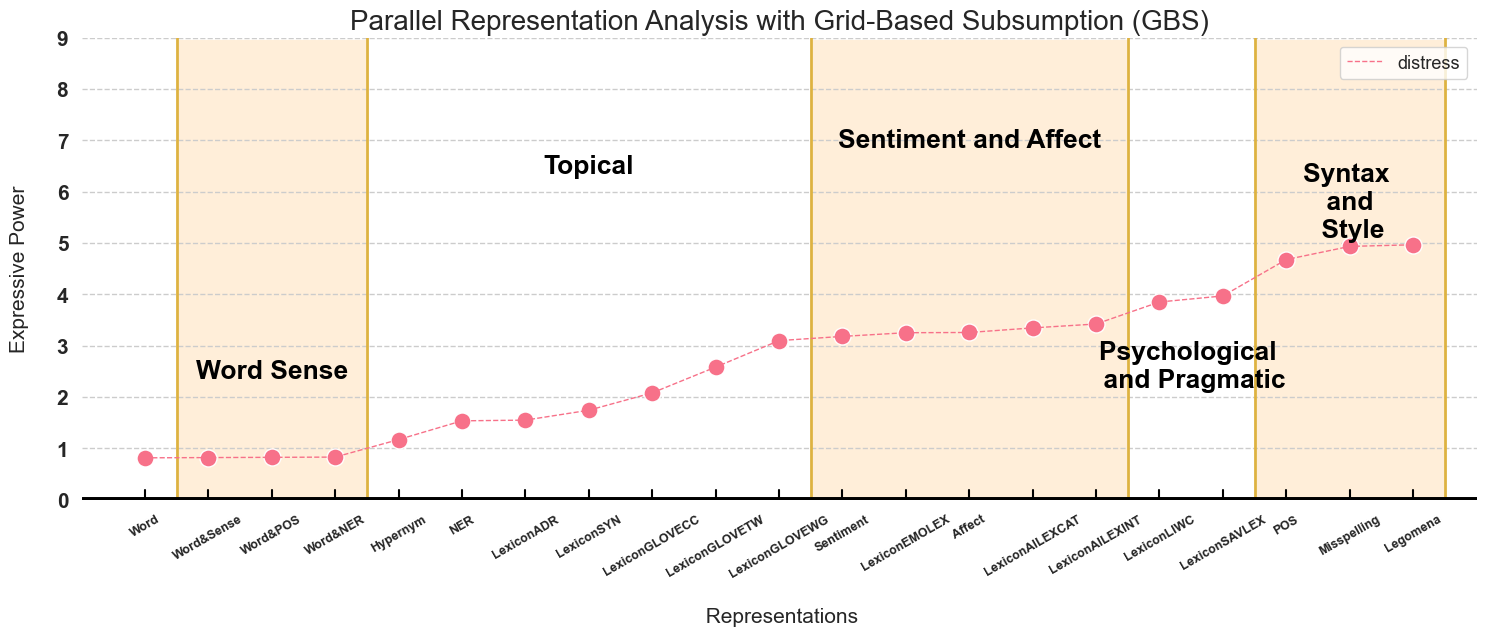

In [19]:
### Set the parameters ###
textagon_output_folder = folder_path
data_name = 'distress'
analysis_output_addr = './'

if 'result_GBS.csv' not in os.listdir(textagon_output_folder):
    raise ValueError(f'The result file is not in the folder: {textagon_output_folder}')

correct_data = []
column_names = ["Path", "Index", "Category", "Total", "Number", "Ratio"]
df = pd.read_csv(f'{textagon_output_folder}/result_GBS.csv', names=column_names)
category_ratio_dict = df.set_index('Category')['Ratio'].to_dict()
c = 0
for key in category_ratio_dict.keys():
    c += category_ratio_dict[key]
    category_ratio_dict[key] = c
correct_data.append(category_ratio_dict)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
import re

x_axis = ['Word', 'Word&Sense', 'Word&POS', 'Word&NER', 'Hypernym', 'NER', 'LexiconADR', 'LexiconSYN', 'LexiconGLOVECC', 'LexiconGLOVETW', 'LexiconGLOVEWG', 'Sentiment', 'LexiconEMOLEX', 'Affect', 'LexiconAILEXCAT', 'LexiconAILEXINT', 'LexiconLIWC', 'LexiconSAVLEX', 'POS', 'Misspelling', 'Legomena']

fig, ax = plt.subplots(figsize=(18, 6)) 
line_styles = [ '--', '-.']

def plot_data(data, label, linestyle, linewidth, color):
    sorted_data = {k: data[k] if k in data else 0 for k in x_axis}
    sns.lineplot(x=x_axis, y=list(sorted_data.values()), sort=False, linewidth=linewidth, linestyle=linestyle, ax=ax, label=data_name, color=color)
    sns.scatterplot(x=x_axis, y=list(sorted_data.values()), s=150, ax=ax, color=color)

highlighted_label = 'FCE/ASAP Human/ChatGPT'
# palette = sns.color_palette(['#9236f5', '#3ea4ed', '#20ab5c', '#e38c22'])
palette = sns.color_palette("husl", len(correct_data))
palette = [color for color in palette if not np.allclose(color, (1.0, 0.0, 0.0))]
# palette = sns.color_palette("husl", len(correct_data))

for i, data in enumerate(correct_data):
    # if legend_names[i] == highlighted_label:
    #     plot_data(data, legend_names[i], '-', 4.5, 'red')
    # else:
    plot_data(data, data_name, line_styles[i % len(line_styles)], (i % 3) + 1, palette[i % len(palette)])

ax.legend()

rectangle_1 = patches.Rectangle((0.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_1.set_clip_on(False)
plt.axvline(0.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(3.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_1)

rectangle_2 = patches.Rectangle((10.5, 0), 5, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_2.set_clip_on(False)
plt.axvline(10.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(15.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_2)

rectangle_3 = patches.Rectangle((17.5, 0), 3, 9, linewidth=2, facecolor='#FFEED9', fill=True, zorder=0)
rectangle_3.set_clip_on(False)
plt.axvline(17.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
plt.axvline(20.5, 0, 8.5, color='#DEB240', linewidth=2, zorder=1)
ax.add_patch(rectangle_3)

plt.text(2, 2.5, 'Word Sense', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(7, 6.5, 'Topical', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(13, 7, 'Sentiment and Affect', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(16.5, 2.6, 'Psychological \n and Pragmatic', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')
plt.text(19, 5.8, 'Syntax \n and \n Style', horizontalalignment='center', verticalalignment='center', fontsize=19, color='black', weight='bold')

plt.axhline(0, color='black', linewidth=5, zorder=1)
plt.xticks(rotation=45, weight='bold', fontsize=15)
plt.yticks(weight='bold', fontsize=15)

sns.despine(top=True, right=True, left=True, bottom=True)
sns.set_style("whitegrid")
sns.set(style="whitegrid", rc={'axes.grid': True, 'grid.linestyle': '--'})
ax.xaxis.grid(False)
ax.set_ylim(0, 9)
ax.legend(fontsize=13)
ax.set_xticklabels(x_axis, rotation=30, weight='bold', fontsize=9)

def add_ticks_for_labels():
    for i, _ in enumerate(x_axis):
        ax.axvline(i, 0, 0.02, color='black')  # Here, 0.02 defines the length of the tick relative to y-axis
add_ticks_for_labels() 

plt.xlabel("\n Representations", fontsize=15)
plt.ylabel("Expressive Power\n", fontsize=15)
plt.title("Parallel Representation Analysis with Grid-Based Subsumption (GBS)", fontsize=20)

plt.savefig(f'{analysis_output_addr}/GBS_{data_name}.pdf', bbox_inches='tight')

plt.show()
